In [1]:
!pip install numpy pandas torch matplotlib seaborn geomloss scikit-learn

Starting training on benign samples only...
Epoch [1/50], Sinkhorn Loss: 0.5789
Epoch [2/50], Sinkhorn Loss: 0.3326
Epoch [3/50], Sinkhorn Loss: 0.2687
Epoch [4/50], Sinkhorn Loss: 0.2519
Epoch [5/50], Sinkhorn Loss: 0.2408
Epoch [6/50], Sinkhorn Loss: 0.2360
Epoch [7/50], Sinkhorn Loss: 0.2260
Epoch [8/50], Sinkhorn Loss: 0.2210
Epoch [9/50], Sinkhorn Loss: 0.2139
Epoch [10/50], Sinkhorn Loss: 0.2047
Epoch [11/50], Sinkhorn Loss: 0.2055
Epoch [12/50], Sinkhorn Loss: 0.2000
Epoch [13/50], Sinkhorn Loss: 0.1944
Epoch [14/50], Sinkhorn Loss: 0.1936
Epoch [15/50], Sinkhorn Loss: 0.1955
Epoch [16/50], Sinkhorn Loss: 0.1909
Epoch [17/50], Sinkhorn Loss: 0.1885
Epoch [18/50], Sinkhorn Loss: 0.1805
Epoch [19/50], Sinkhorn Loss: 0.1873
Epoch [20/50], Sinkhorn Loss: 0.1819
Epoch [21/50], Sinkhorn Loss: 0.1807
Epoch [22/50], Sinkhorn Loss: 0.1804
Epoch [23/50], Sinkhorn Loss: 0.1669
Epoch [24/50], Sinkhorn Loss: 0.1761
Epoch [25/50], Sinkhorn Loss: 0.1724
Epoch [26/50], Sinkhorn Loss: 0.1736
Epo

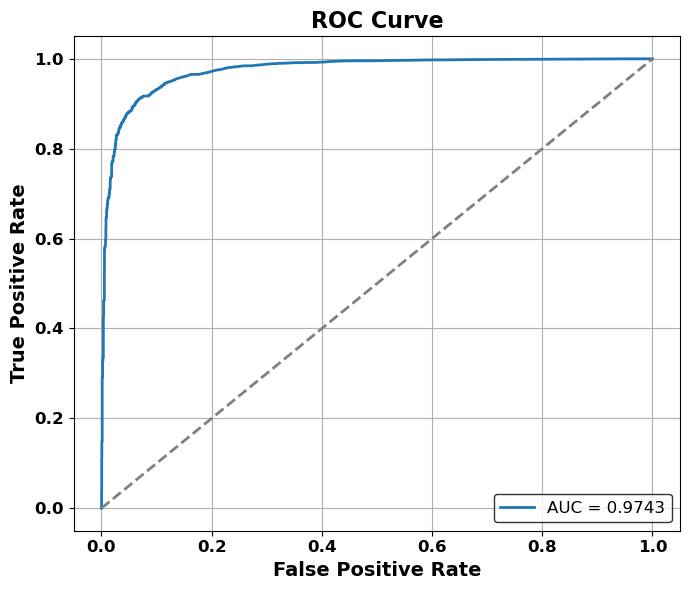

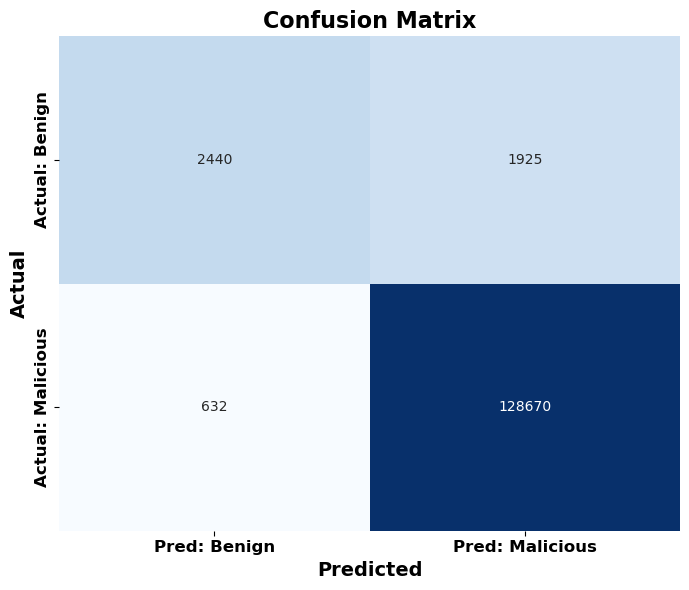

In [5]:
import numpy as np
import pandas as pd
import torch
import time
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from geomloss import SamplesLoss  # Sinkhorn divergence
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score,roc_curve, auc

# ---------------------------
#  Hyperparameters & Settings
# ---------------------------
batch_size = 64
latent_dim = 100
num_features = 17  # based on training data
lr = 0.0002
epochs = 50
threshold_percentile = 95

# ---------------------------
#  Generator Network
# ---------------------------
class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, output_dim)
        )
    
    def forward(self, z):
        return self.net(z)

# ---------------------------
#  Training Function
# ---------------------------
def train(generator, dataloader, sinkhorn_loss_fn, optimizer, device):
    generator.train()
    for epoch in range(epochs):
        total_loss = 0.0
        for batch in dataloader:
            real_data = batch[0].to(device)
            current_batch_size = real_data.size(0)
            
            optimizer.zero_grad()
            z = torch.randn(current_batch_size, latent_dim, device=device)
            fake_data = generator(z)
            loss = sinkhorn_loss_fn(real_data, fake_data)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(dataloader)
        print(f"Epoch [{epoch+1}/{epochs}], Sinkhorn Loss: {avg_loss:.4f}")
    return generator

# ---------------------------
#  Fast Batch-Based Anomaly Score Computation
# ---------------------------
def compute_anomaly_scores_fast(generator, data_tensor, sinkhorn_loss_fn, device):
    generator.eval()
    all_scores = []
    dataloader = DataLoader(data_tensor, batch_size=batch_size, shuffle=False)
    with torch.no_grad():
        for batch in dataloader:
            real_data = batch.to(device)
            z = torch.randn(real_data.size(0), latent_dim, device=device)
            fake_data = generator(z)
            loss = sinkhorn_loss_fn(real_data, fake_data)
            all_scores.extend([loss.item()] * real_data.size(0))  # same score for batch
    return np.array(all_scores)

# ---------------------------
#  Main
# ---------------------------
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 1) Load Data
    df = pd.read_csv("AUGXUDP.csv")

    # 2) Define Label Columns
    label_cols = ["Class_BENIGN", "Class_UDP-lag", "Class_WebDDoS"]

    # 3) Prepare Training Data (Benign Only)
    df_benign = df[df["Class_BENIGN"] == 1].copy()
    df_benign_features = df_benign.drop(columns=label_cols)
    real_data_np = df_benign_features.values.astype(np.float32)
    num_features = real_data_np.shape[1]  # Automatically detect number of features

    dataset = TensorDataset(torch.tensor(real_data_np))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # 4) Initialize Model and Loss
    generator = Generator(latent_dim, num_features).to(device)
    sinkhorn_loss_fn = SamplesLoss(loss="sinkhorn", p=2, blur=0.05)
    optimizer = optim.Adam(generator.parameters(), lr=lr)

    # 5) Train the Model
    print("Starting training on benign samples only...")
    start_train = time.time()
    trained_generator = train(generator, dataloader, sinkhorn_loss_fn, optimizer, device)
    end_train = time.time()
    print(f"\nTraining Time: {end_train - start_train:.4f} seconds\n")

    # 6) Prepare Test Data (Benign + Malicious)
    df_test = df.copy()
    df_test_features = df_test.drop(columns=label_cols).values.astype(np.float32)
    test_tensor = torch.tensor(df_test_features)

    # 7) Create Ground Truth Labels
    y_true = (df_test["Class_BENIGN"] != 1).astype(int).values  # 0 = benign, 1 = malicious

    # 8) Compute Anomaly Scores
    # 8) Compute Anomaly Scores
    print("Computing anomaly scores on the test set...")
    start_infer = time.time()
    anomaly_scores = compute_anomaly_scores_fast(trained_generator, test_tensor, sinkhorn_loss_fn, device)
    end_infer = time.time()
    print(f"\nInference Time: {end_infer - start_infer:.4f} seconds\n")

    # 9) Compute Training Scores for Thresholding
    train_scores = compute_anomaly_scores_fast(trained_generator,
                                               torch.tensor(real_data_np),
                                               sinkhorn_loss_fn,
                                               device)
    threshold = np.percentile(train_scores, threshold_percentile)
    print(f"Using {threshold_percentile}th percentile threshold: {threshold:.4f}")

    # 10) Predictions
    y_pred = (anomaly_scores > threshold).astype(int)

    # 11) Evaluation
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    accuracy = (tp + tn) / (tn + fp + fn + tp)

    print("=== Evaluation Metrics ===")
    print(f"Confusion Matrix:\n{cm}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"Accuracy:  {accuracy:.4f}")
    
fpr, tpr, _ = roc_curve(y_true, anomaly_scores) 
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}", linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2)

plt.xlabel("False Positive Rate", fontsize=14, fontweight='bold')
plt.ylabel("True Positive Rate", fontsize=14, fontweight='bold')
plt.title("ROC Curve", fontsize=16, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.legend(loc="lower right", fontsize=12, frameon=True, facecolor='white', edgecolor='black')
plt.grid(True)
plt.tight_layout()
plt.show()

# confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(7, 6))
sns.heatmap(conf_matrix,
            annot=True,
            fmt='d',
            cmap='Blues',
            norm=LogNorm(),  
            cbar=False,
            xticklabels=['Pred: Benign', 'Pred: Malicious'],
            yticklabels=['Actual: Benign', 'Actual: Malicious'])

plt.xlabel("Predicted", fontsize=14, fontweight='bold')
plt.ylabel("Actual", fontsize=14, fontweight='bold')
plt.title("Confusion Matrix", fontsize=16, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()
